## Q1

**Stochastic Processes**
- a way to simulate random processes that we can't deterministically define or are too computationally intensive to deterministically define 
- statstically, they are a collection of random variables that are ordered in some way (usually time or space)

**Gaussian Processes (GPs)**
- special case of stochastic processes where every combination of random variables in the process has a joint distribution that describes a MVN random variable
- this is useful when we have a random variable that is a function rather than a vector/scalar
    - we can still give it the Bayesian treatment via a prior with support over continuous functions
    - this prior on $f(x)$ is often a GP which is parameterized as $f(x) \sim GP(m(x), k(x, x'))$ ($m$ is the mean function, $k$ is the covariance function, $x'$ are all the given data without observation $x$)
    - GPs model values of $f(x)$ as draws from $MVN(m(x), k(x, x'))$ (which we can tractably do)

**Variational inference using the Evidence Lower Bound (ELBO)**
- ELBO is a lower bound (i.e. a worst case) on the log likelihood of the distribution that models a dataset
- this can be used as a loss function for a neural network as making the ELBO larger means that our model is more likely given the data
- ELBO is calculated as $E_q[\log p(x, Z)] − E_q[\log q(Z)]$ where $x$ is the data, $Z$ are some latent variables, $p$ is the joint distribution, and $q$ is a proxy for the posterior 
    - we sometimes can't find a closed form for the posterior so we define a family of distributions with their own parameters $q$ and estimate parameters that make $q$ close to the posterior (this is roughly variational inference) 
    - so using ELBO is a way of fitting the parameters for $q$ and therefore estimating the posterior
    - since $q$ is a random variable on a family of functions, we can model $q$ with a GP

## Q2

[Text(0.5, 0, 'Weeks since beginning of 2021'),
 Text(0, 0.5, 'log weekly average viral load of covid-19 (copies/mL)')]

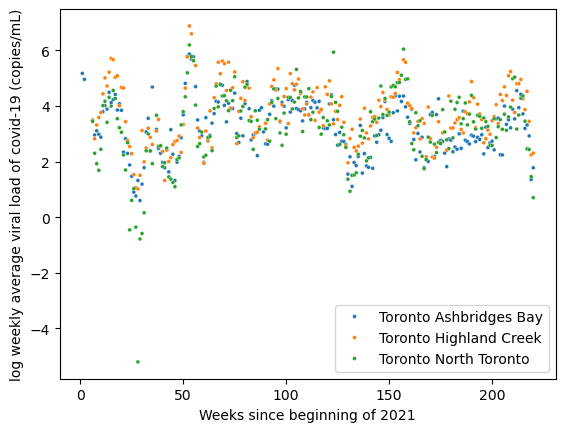

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
# Covid wastewater data 
url = "https://health-infobase.canada.ca/src/data/wastewater/wastewater_aggregate.csv"
data = pd.read_csv(url)
data = data.iloc[list(data["measureid"] == 'covN2'), :]
data = data.iloc[list(np.logical_or(np.logical_or(data["Location"] == 'Toronto Highland Creek',data["Location"] == "Toronto North Toronto"), data["Location"] == "Toronto Ashbridges Bay")),:]
#data = data.iloc[list(data["Location"] == 'Toronto Highland Creek'),:]

data["date"] = data["EpiWeek"] + (data["EpiYear"] - 2021)*52
data = data.iloc[list(data["date"] >= 0), :]
data["w_avg"] = np.log(data["w_avg"])
date = data["date"].to_numpy().flatten()
time_pipeline = Pipeline(steps=[("scaler", StandardScaler())])
time_pipeline.fit(date.reshape(-1, 1))
date_std = time_pipeline["scaler"].scale_.item()
date_norm = time_pipeline.transform(date.reshape(-1, 1)).flatten()

week = data["EpiWeek"].to_numpy()
year = data["EpiYear"].to_numpy()
viral = data["w_avg"].to_numpy()
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="date", y="w_avg", c="C0", s=8, ax=ax, hue='Location')
ax.legend()
ax.set(xlabel="Weeks since beginning of 2021", ylabel="log weekly average viral load of covid-19 (copies/mL)")

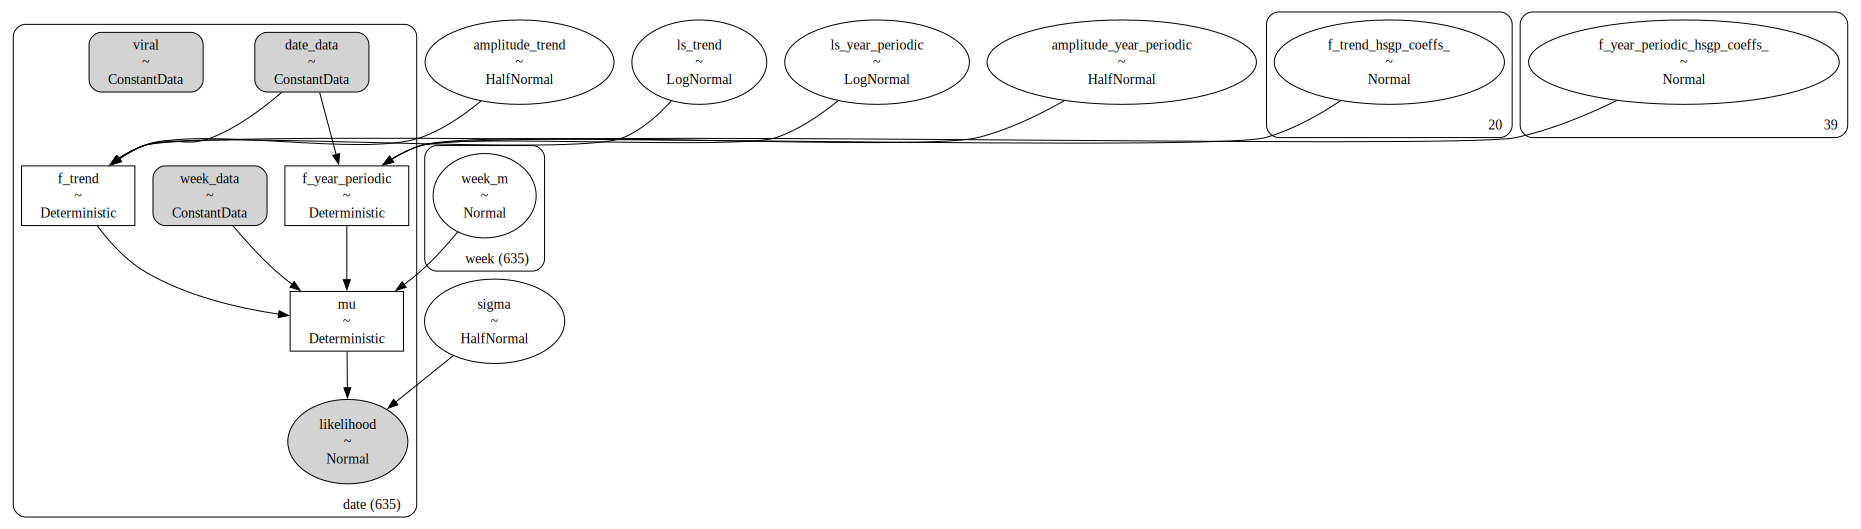

In [2]:
# code from https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Births.html
coords = {
    "date": date,
    "week": week,
    "year": year,
}
X = data.to_numpy()
with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    date_data = pm.Data(
        name="date_data", value=date_norm, mutable=False, dims="date"
    )

    week_data = pm.Data(
        name="week_data", value=week, mutable=False, dims="date"
    )
    viral_data = pm.Data(
        name="viral",
        value=viral,
        mutable=False,
        dims="date",
    )

    # --- Priors ---

    # global trend
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.LogNormal(name="ls_trend", mu=np.log(60 / date_std), sigma=1)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=date_data[:, None], dims="date")

    ## year periodic
    amplitude_year_periodic = pm.HalfNormal(name="amplitude_year_periodic", sigma=1)
    ls_year_periodic = pm.LogNormal(name="ls_year_periodic", mu=np.log(600 / date_std), sigma=1)
    gp_year_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_year_periodic,
        cov_func=pm.gp.cov.Periodic(input_dim=1, period=52.1429 / date_std, ls=ls_year_periodic),
    )
    f_year_periodic = gp_year_periodic.prior(
        name="f_year_periodic", X=date_data[:, None], dims="date"
    )

    ## week
    week_m = pm.Normal(
        name="week_m", sigma=1, dims="week"
    )

    # global noise
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=f_trend
        + f_year_periodic
        + week_m[week_data] * (week_data > 0),
        dims="date",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=viral,
        dims="date",
    )

pm.model_to_graphviz(model=model)

In [3]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=2000, random_seed=365)

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [amplitude_trend, amplitude_year_periodic, f_trend_hsgp_coeffs_, f_year_periodic_hsgp_coeffs_, likelihood, ls_trend, ls_year_periodic, sigma, week_m]


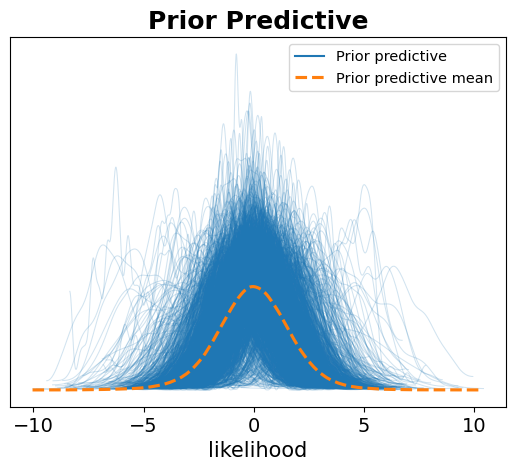

In [4]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold");

In [5]:
!pip install numpyro

with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=2000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=365,
    )
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=365))

  Using cached numpyro-0.18.0-py3-none-any.whl.metadata (37 kB)
Using cached numpyro-0.18.0-py3-none-any.whl (365 kB)


/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Compiling...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/s

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:00:06.503900
Transforming variables...
Transformation time = 0:01:53.020058
Sampling: [likelihood]


In [6]:
var_names = [
    "amplitude_trend",
    "ls_trend",
    "amplitude_year_periodic",
    "ls_year_periodic",
    "week_m",
    "sigma"
]
idata["sample_stats"]["diverging"].sum().item()
# only 4 divergences is okay

4

Text(0.5, 1.0, 'Covid-19 waste water viral load in Toronto\n    Posterior Predictive (Likelihood)')

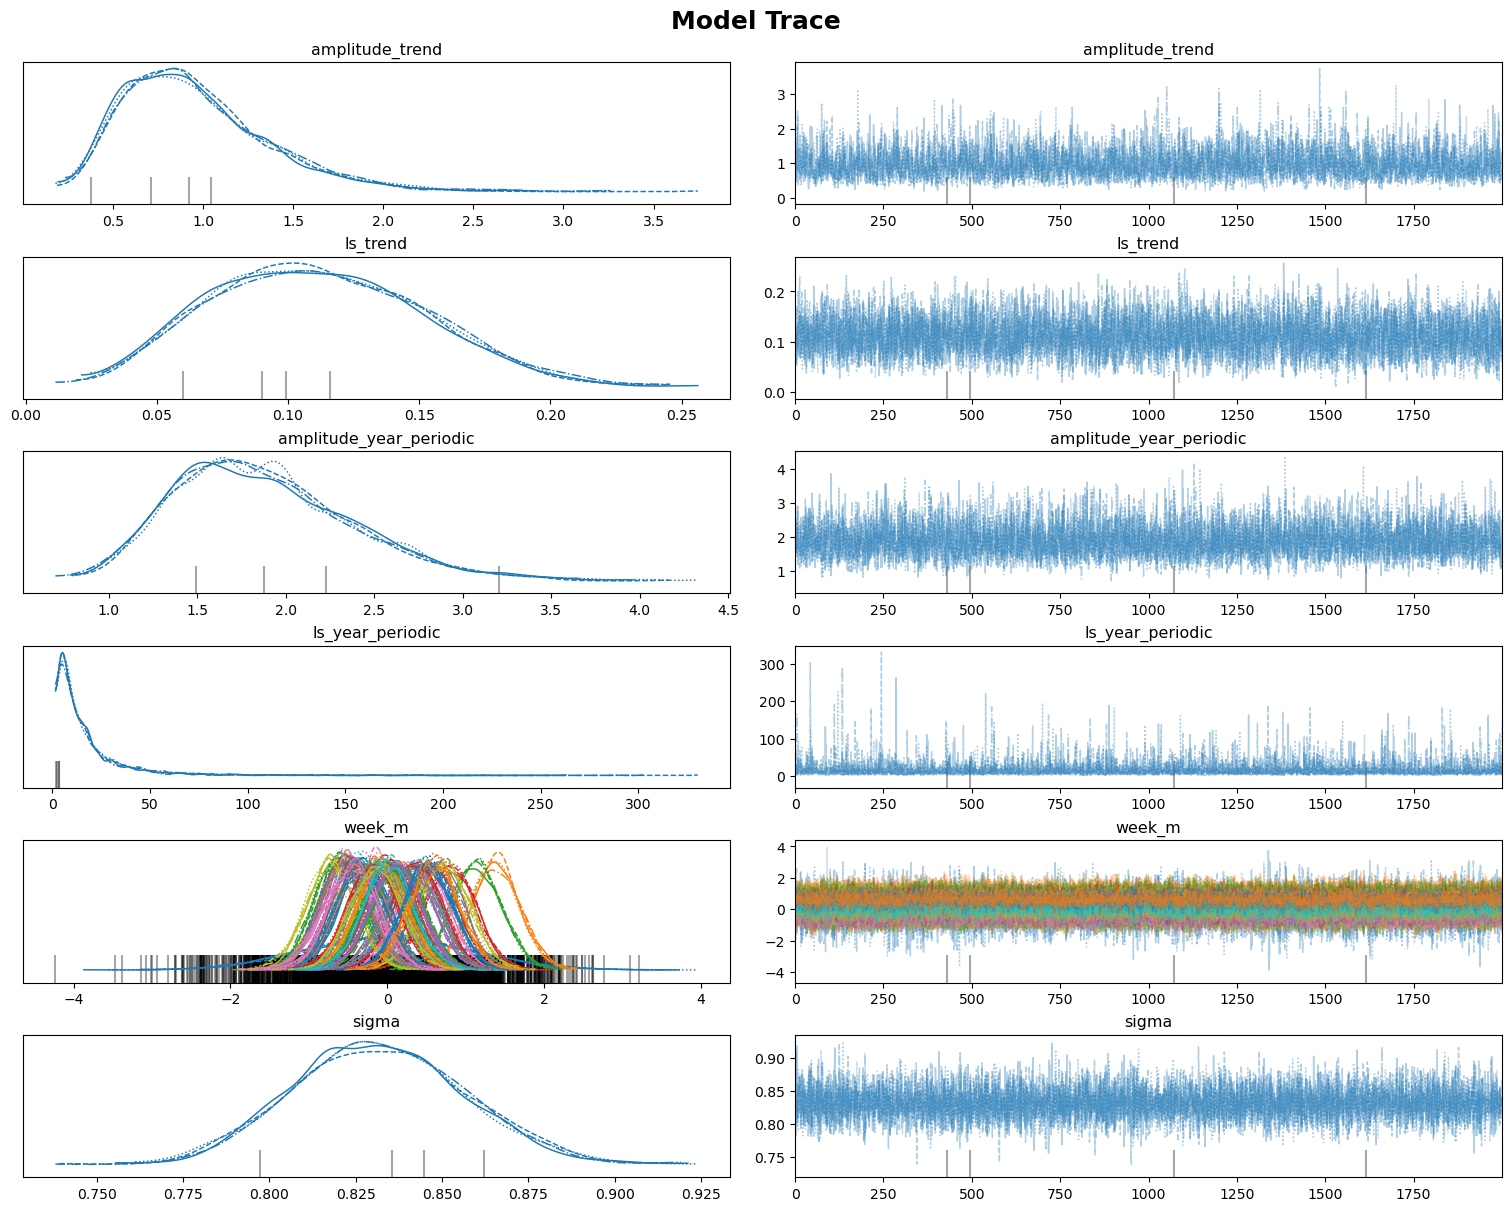

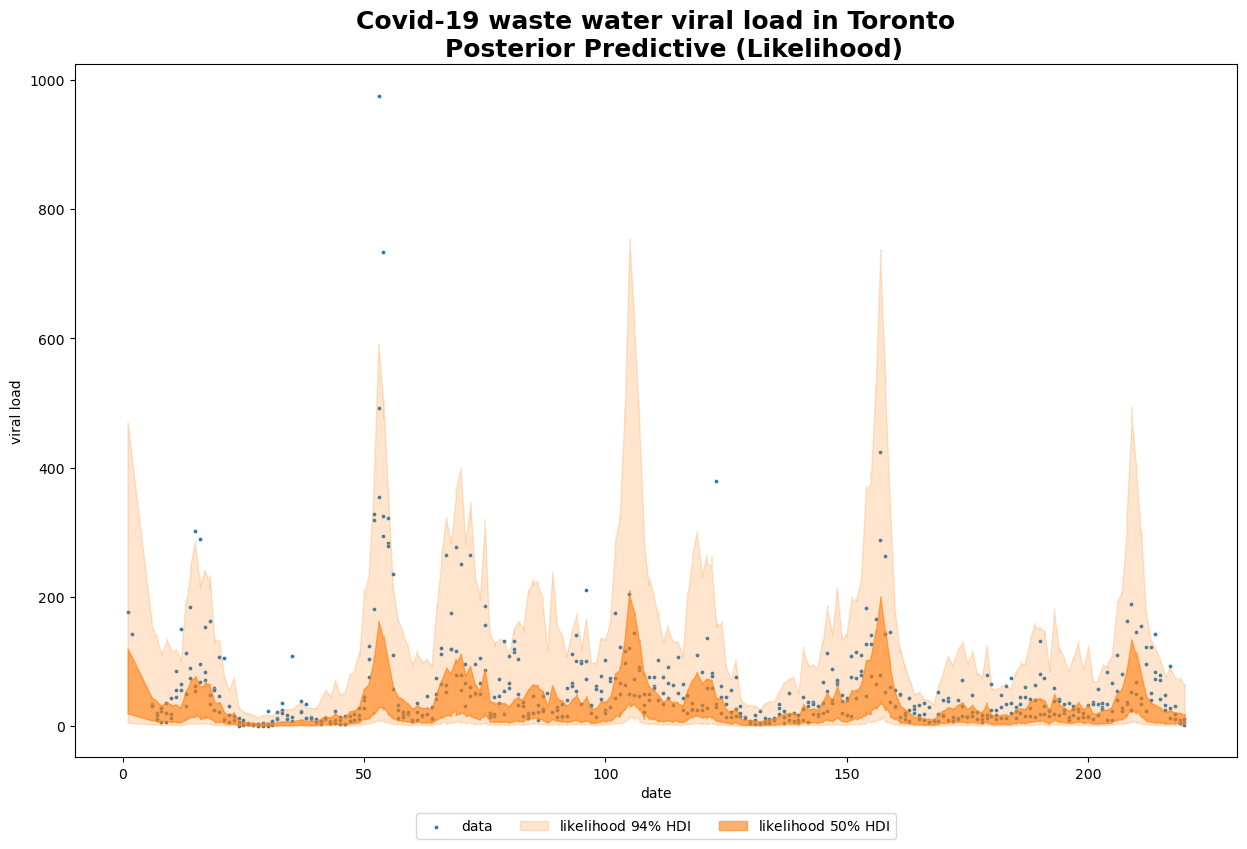

In [7]:
from collections.abc import Callable
import xarray as xr

axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

def apply_fn_along_dims(fn: Callable, a: xr.DataArray, dim: str) -> xr.DataArray:
    """Apply a function along a specific dimension.

    We need to expand the dimensions of the input array to make it compatible with the
    function which we assume acts on a matrix.
    """
    return xr.apply_ufunc(
        fn,
        a.expand_dims(
            dim={"_": 1}, axis=-1
        ),  # The auxiliary dimension `_` is used to broadcast the function.
        input_core_dims=[[dim, "_"]],
        output_core_dims=[[dim, "_"]],
        vectorize=True,
    ).squeeze(dim="_")

pp_vars_original_scale = {
    var_name: apply_fn_along_dims(
        fn=np.exp,
        a=idata["posterior"][var_name],
        dim="date",
    )
    for var_name in ["f_trend", "f_year_periodic"]
}
pp_vars_original_scale["f_trend_periodic"] = apply_fn_along_dims(
    fn=np.exp,
    a=idata["posterior"]["f_trend"] + idata["posterior"]["f_year_periodic"],
    dim="date",
)

pp_likelihood_original_scale = apply_fn_along_dims(
    fn=np.exp,
    a=idata["posterior_predictive"]["likelihood"],
    dim="date",
)

fig, ax = plt.subplots(figsize=(15, 9))
sns.scatterplot(data=data, x="date", y=np.exp(viral), c="C0", s=8, label="data", ax=ax)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.6, "label": r"likelihood $50\%$ HDI"},
    smooth=False,
    ax=ax,
)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=4)
ax.set(xlabel="date", ylabel="viral load")
ax.set_title(
    label="""Covid-19 waste water viral load in Toronto
    Posterior Predictive (Likelihood)""",
    fontsize=18,
    fontweight="bold",
)




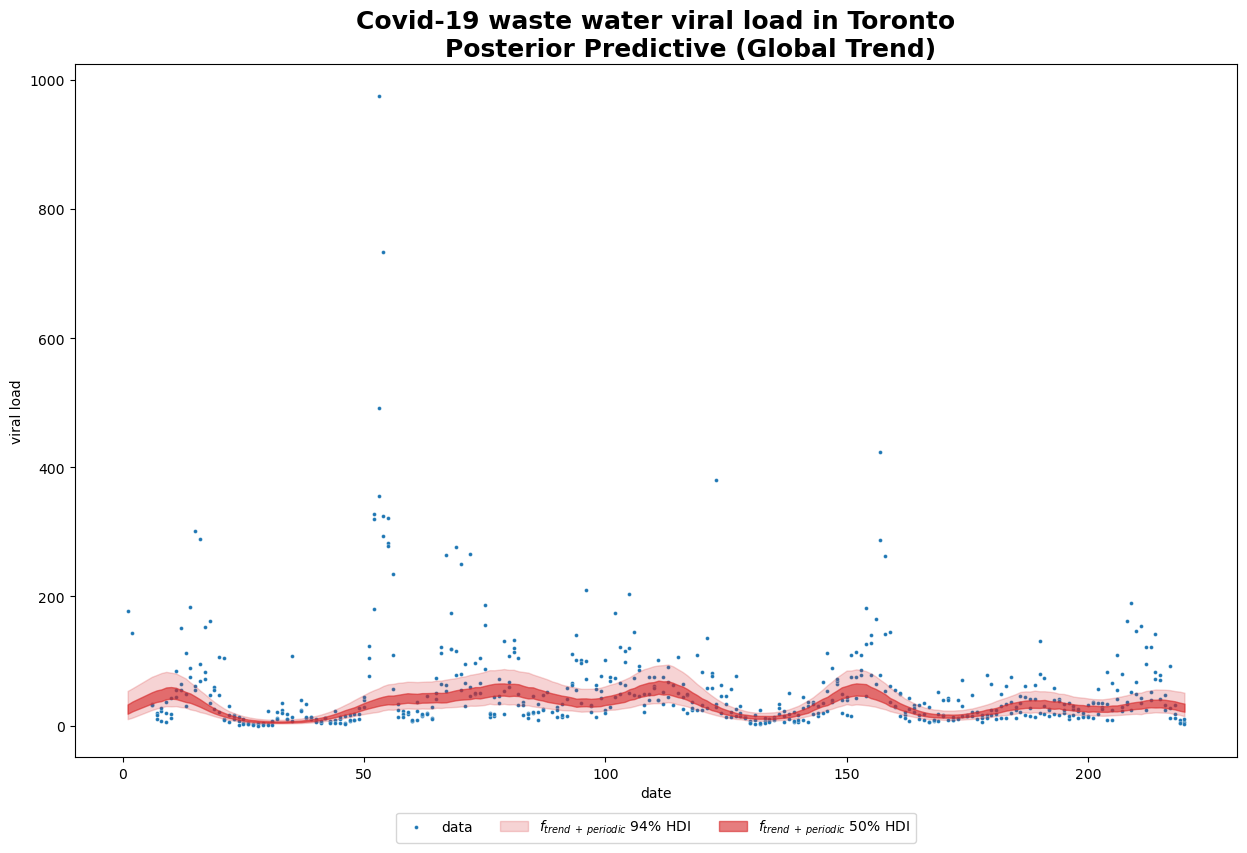

In [8]:
def plot_component(
    component_name: str, color: str, component_label: str
) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=(15, 9))
    sns.scatterplot(
        data=data, x="date", y=np.exp(viral), c="C0", s=8, label="data", ax=ax
    )
    az.plot_hdi(
        x=date,
        y=pp_vars_original_scale[component_name],
        hdi_prob=0.94,
        color=color,
        fill_kwargs={"alpha": 0.2, "label": rf"{component_label} $94\%$ HDI"},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x=date,
        y=pp_vars_original_scale[component_name],
        hdi_prob=0.5,
        color=color,
        fill_kwargs={"alpha": 0.6, "label": rf"{component_label} $50\%$ HDI"},
        smooth=False,
        ax=ax,
    )
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=4)
    ax.set(xlabel="date", ylabel="viral load")
    ax.set_title(
        label="""Covid-19 waste water viral load in Toronto
        Posterior Predictive (Global Trend)""",
        fontsize=18,
        fontweight="bold",
    )
    return fig, ax

fig, ax = plot_component(
    component_name="f_trend_periodic",
    color="C3",
    component_label=r"$f_{trend \: + \: periodic}$"
)
# cool wiggly line

## Q3

[Text(0.5, 0, 'Weeks since beginning of 2021'),
 Text(0, 0.5, 'weekly average viral load of covid-19 (copies/mL)')]

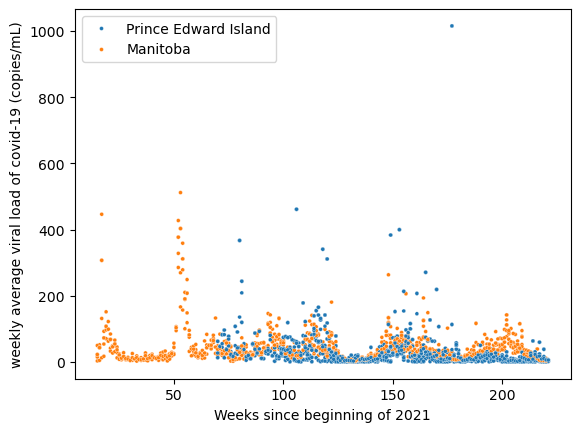

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
rng = np.random.default_rng(365)
floatX = pytensor.config.floatX

# Covid wastewater data 
url = "https://health-infobase.canada.ca/src/data/wastewater/wastewater_aggregate.csv"
data = pd.read_csv(url)
data = data.iloc[list(data["measureid"] == 'covN2'), :]
data = data.iloc[list(np.logical_or(data["province"] == 'Prince Edward Island',data["province"] == "Manitoba")),:]

data["date"] = data["EpiWeek"] + (data["EpiYear"] - 2021)*52
data = data.iloc[list(data["date"] >= 0), :]
Y = np.array(data["province"] == 'Prince Edward Island')
X = data[["date", "w_avg"]]

X = scale(X)
X = np.hstack((np.ones((X.shape[0],1)),X))
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="date", y="w_avg", c="C0", s=8, ax=ax, hue='province')

ax.legend()
ax.set(xlabel="Weeks since beginning of 2021", ylabel="weekly average viral load of covid-19 (copies/mL)")

# data is pretty noisy, want to predict province from time and corresponding covid 19 viral load

In [2]:
# code from https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html
def construct_nn(batch_size=50):
    n_hidden = 100

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }

    with pm.Model(coords=coords) as neural_network:

        # Define data variables using minibatches
        X_data = pm.Data("X_data", X_train, dims=("obs_id", "train_cols"))
        Y_data = pm.Data("Y_data", Y_train, dims="obs_id")

        # Define minibatch variables
        ann_input, ann_output = pm.Minibatch(X_data, Y_data, batch_size=batch_size)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=X_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


# Create the neural network model
neural_network = construct_nn()

/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [3]:
with neural_network:
    approx = pm.fit(n=50000)

Finished [100%]: Average Loss = 72.133


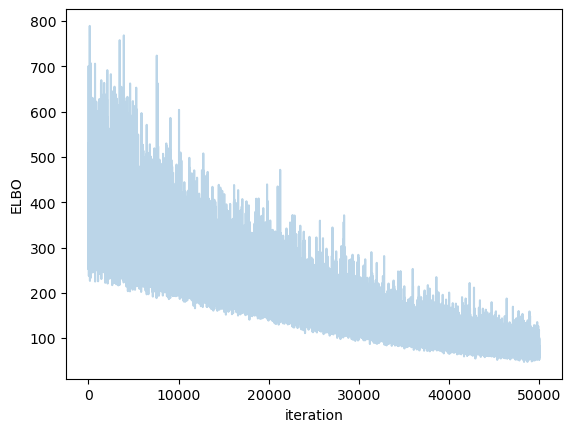

In [4]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");



In [4]:
trace = approx.sample(draws=1000)

def sample_posterior_predictive(X_test, Y_test, trace, n_hidden=100):
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }
    with pm.Model(coords=coords):

        ann_input = X_test
        ann_output = Y_test

        weights_in_1 = pm.Flat("w_in_1", dims=("train_cols", "hidden_layer_1"))
        weights_1_2 = pm.Flat("w_1_2", dims=("hidden_layer_1", "hidden_layer_2"))
        weights_2_out = pm.Flat("w_2_out", dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli("out", act_out, observed=ann_output)
        return pm.sample_posterior_predictive(trace)


ppc = sample_posterior_predictive(X_test, Y_test, trace)

/opt/conda/lib/python3.11/site-packages/pymc/backends/arviz.py:60: UserWarning: Could not extract data from symbolic observation out
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [out]


Accuracy = 63.43%


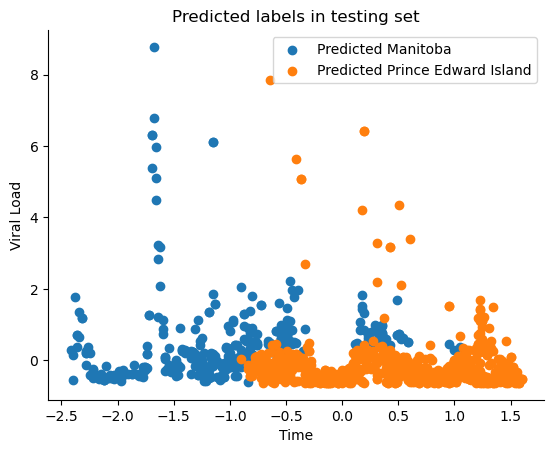

In [5]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 1], X_test[pred == 0, 2], color="C0", label="Predicted Manitoba")
ax.scatter(X_test[pred == 1, 1], X_test[pred == 1, 2], color="C1", label="Predicted Prince Edward Island")
sns.despine()
ax.legend()
ax.set(title="Predicted labels in testing set", xlabel="Time", ylabel="Viral Load")

print(f"Accuracy = {(Y_test == pred.values).mean() * 100:.2f}%")
# pretty low accuracy, but the data is also pretty noisy

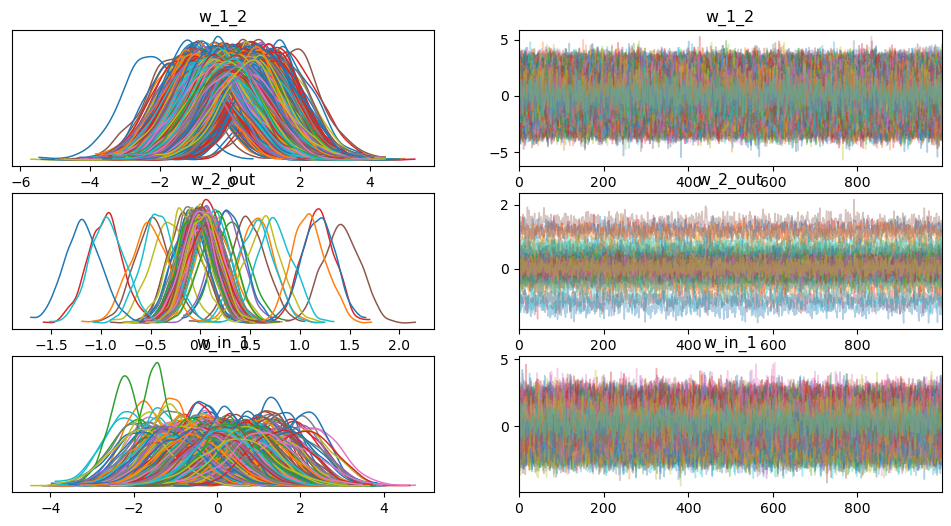

In [7]:
az.plot_trace(trace);

# I did specify 100 hidden units after all...

Sampling: [out]


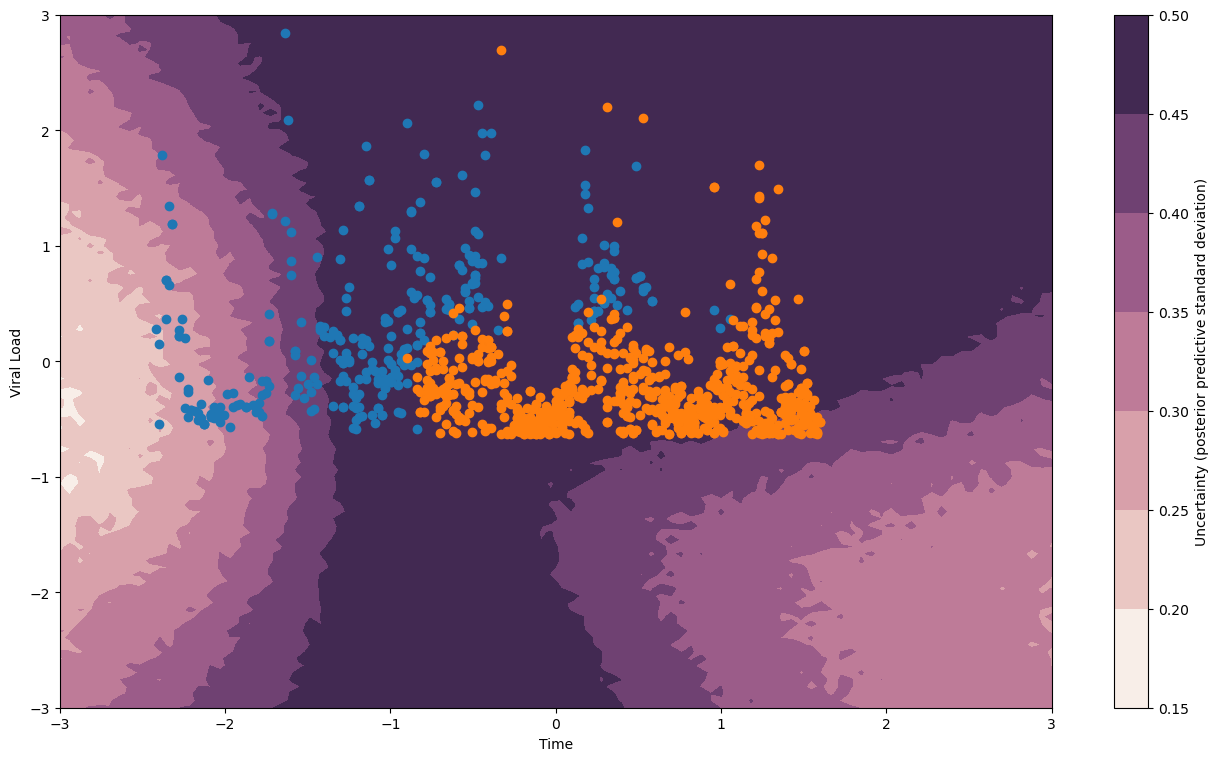

In [6]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
grid_2d = np.hstack((np.ones((grid_2d.shape[0],1)), grid_2d))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)
ppc = sample_posterior_predictive(grid_2d, dummy_out, trace)

y_pred = ppc.posterior_predictive["out"]

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.squeeze().values.std(axis=0).reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 1], X_test[pred == 0, 2], color="C0")
ax.scatter(X_test[pred == 1, 1], X_test[pred == 1, 2], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="Time", ylabel="Viral Load")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)")

# neural network picks up on Manitoba having earlier data than PEI
# but for the bulk of the area, there's pretty high uncertainty due to the data not being very well separated